## Sequential Outlier Example
### Pseudocode

```
Algorithm SequentialEnsemble(Data Set: D, Base Algorithms: A1 . . . Ar)
begin
    j = 1;
    repeat
        Pick an algorithm Aj based on results from past executions;
        Create a new data set fj (D) from D based on results from past executions;
        Apply Aj to fj(D);
        j = j + 1;
    until(termination);
    report outliers based on combinations of results from previous executions;
end
```

In [1]:
def SequentialEnsemble(D, A, **kwargs):
    """
    D: Data Set
    A: List of Base Algorithms
    """
    
    def pick_algorithm(j, past_results):
        """
        Logic to pick the algorithm based on past results.
        """
        return A[j]
    
    def create_new_dataset(D, past_results):
        """Add past results as new features to the dataset"""
        for result in past_results:
            D = np.hstack([D, result.reshape(-1, 1)])
        return D
    
    def apply_algorithm(Aj, fj_D):
        """
        Apply selected algorithm to the data.
        """
        return Aj(fj_D)
    
    def termination_condition(j, D):
        """
        Logic to decide termination.
        """
        return j == len(A)
    
    def report_outliers(past_results):
        """
        Logic to report outliers based on combinations of results from previous executions.
        """
        return past_results[-1]

    pick_algorithm = kwargs.get("pick_algorithm", pick_algorithm)
    create_new_dataset = kwargs.get("create_new_dataset", create_new_dataset)
    apply_algorithm = kwargs.get("apply_algorithm", apply_algorithm)
    termination_condition = kwargs.get("termination_condition", termination_condition)
    report_outliers = kwargs.get("report_outliers", report_outliers)

    j = 0
    past_results = []
    while not termination_condition(j, D):
        Aj = pick_algorithm(j, past_results)
        fj_D = create_new_dataset(D, past_results)
        
        results = apply_algorithm(Aj, fj_D)
        past_results.append(results)
        
        j += 1
    
    outliers = report_outliers(past_results)  
    return outliers

Outlier-scores (report_outliers last):
 Normal:    [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1
 -1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1
  1 -1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1 -1
  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
 -1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1
  1  1  1  1  1  1  1  1]
 Outliers:  [-1 -1 -1]


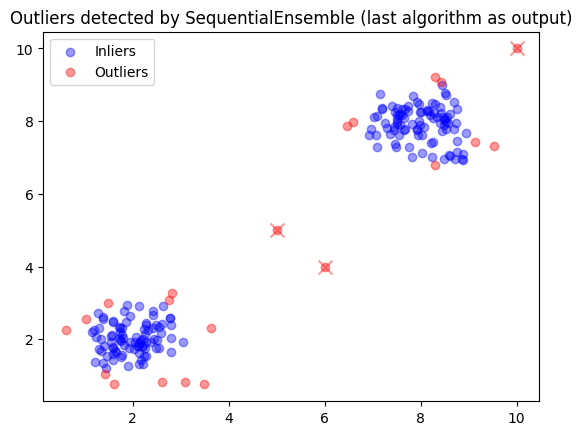

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.datasets import make_blobs

def simpledata():
    # Sample data generation
    data, _ = make_blobs(n_samples=100, centers=1, cluster_std=0.60, random_state=0)
    
    # Add some outliers
    outlier_labels = np.array([[4, 5], [-4, -4]])
    X = np.vstack([data, outlier_labels])
    return X, data, outlier_labels

def twoclusterdata():
    # Sample data generation (two clusters)
    cluster1 = np.random.randn(100, 2) * [0.5, 0.5] + [2, 2]
    cluster2 = np.random.randn(100, 2) * [0.5, 0.5] + [8, 8]
    data = np.vstack([cluster1, cluster2])

    # Add some outliers
    outlier_labels = np.array([[5, 5],[10, 10], [6, 4]])
    X = np.vstack([data, outlier_labels])
    return X, data, outlier_labels

X, data, outlier_labels = twoclusterdata()

# Define the outlier detection algorithms
def alg1(data):
    clf = LocalOutlierFactor(contamination=0.01)
    return clf.fit_predict(data)

def alg2(data):
    clf = OneClassSVM(nu=0.05)
    clf.fit(data)
    return clf.predict(data)

def alg3(data):
    clf = IsolationForest(contamination=0.1)
    clf.fit(data)
    return clf.predict(data)

algorithms = [alg1, alg2, alg3]

def avg_report_outliers(past_results):
        return sum(past_results) / len(past_results)

outliers = SequentialEnsemble(X, algorithms)

# Reporting
print("Outlier-scores (report_outliers last):")
print(" Normal:   ",np.array2string(outliers[:len(data)], formatter={'float_kind': lambda x: "{:.2}".format(x)}))
print(" Outliers: ",np.array2string(outliers[len(data):], formatter={'float_kind': lambda x: "{:.2}".format(x)}))

# Plot
plt.scatter(X[outliers >= 0][:, 0], X[outliers >= 0][:, 1], color='blue', label='Inliers', alpha=0.4)
plt.scatter(X[outliers < 0][:, 0], X[outliers < 0][:, 1], color='red', label='Outliers', alpha=0.4)

plt.scatter(outlier_labels[:, 0], outlier_labels[:, 1], c='red', marker='x', s=100, alpha=0.4)
  
plt.title('Outliers detected by SequentialEnsemble (last algorithm as output)')
plt.legend()
plt.show()


Outlier-scores (avg_report_outliers):
 Normal:    [1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.33 1.0
 1.0 1.0 1.0 1.0 1.0 1.0 -0.33 1.0 1.0 1.0 -0.33 1.0 1.0 1.0 1.0 1.0 1.0
 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 -0.33 1.0 1.0 1.0 1.0 0.33 1.0 1.0
 1.0 -0.33 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.33 1.0 1.0 1.0 1.0 1.0 -0.33 1.0 1.0 1.0
 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.33 1.0 1.0 1.0 -0.33 1.0 1.0 1.0
 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.33 1.0 1.0 1.0 0.33 1.0
 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 -0.33 0.33 1.0 1.0 1.0 1.0 1.0 0.33 1.0
 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 -0.33 1.0 1.0 1.0 1.0
 0.33 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.33 1.0 1.0 1.0
 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0]
 Outliers:  [-1.0 -1.0 -1.0]


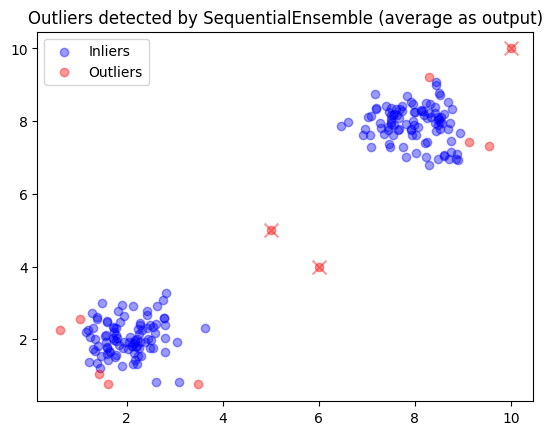

In [3]:
outliers = SequentialEnsemble(X, algorithms, report_outliers=avg_report_outliers)

# Reporting
print("Outlier-scores (avg_report_outliers):")
print(" Normal:   ",np.array2string(outliers[:len(data)], formatter={'float_kind': lambda x: "{:.2}".format(x)}))
print(" Outliers: ",np.array2string(outliers[len(data):], formatter={'float_kind': lambda x: "{:.2}".format(x)}))
    
# Plot
plt.scatter(X[outliers >= 0][:, 0], X[outliers >= 0][:, 1], color='blue', label='Inliers', alpha=0.4)
plt.scatter(X[outliers < 0][:, 0], X[outliers < 0][:, 1], color='red', label='Outliers', alpha=0.4)

plt.scatter(outlier_labels[:, 0], outlier_labels[:, 1], c='red', marker='x', s=100, alpha=0.4)
  
plt.title('Outliers detected by SequentialEnsemble (average as output)')
plt.legend()
plt.show()